# Notebook for training a ML algorithm to predict attractants / repellents for _E. coli_

## PART 4: Build & Train a ML model

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from IPython.display import display

import sys
import joblib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import Descriptors3D

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, root_mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler

import pickle

In [3]:
# Variables
smiles_column='Iso_SMILES' # SMILES to used to convert into RDKit molecules
data_type='descriptors' # descriptors or fingerprint or descrfp
drop_list=['BCUT2D_MWHI','BCUT2D_MWLOW','BCUT2D_CHGHI','BCUT2D_CHGLO','BCUT2D_LOGPHI','BCUT2D_LOGPLOW','BCUT2D_MRHI','BCUT2D_MRLOW']

In [4]:
# ML variables
ml_method='RF'   # RF or NB or SVM
split=0.20   # 80-20 splitting
random_state=123
fp_type='morgancirc' # Fingerprint style to use for the ML model if fingerprints or descrfp is chosen
n_estimators=25   # number of decision trees in the forest
max_features='sqrt' # None, sqrt or log2
max_depth=10   # maximum depth of the tree
max_leaf_nodes=None
max_samples=None
min_samples_split=2   # minimum of samples splitted into an internal node
scaling = None   # Method to scale the input features: MinMax, Normalize or Standard

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

save=False

Number of physical cores: 4


### Generating a ML model

Load one of the dataset with the fingerprint

In [5]:
# The dataset contains ions. As we can see here, ions do not have any 3D descriptors (as it is only a single charged atom).
# Therefore, only the 2D descriptors will be used here (be careful, some values in the 2D descriptors of ions are "nan" and need to be removed).

if data_type == 'descriptors':
    data = pd.read_csv('chemoeffectors_descriptors.csv')
    data.drop(drop_list, axis=1, inplace=True)
    data.dropna(inplace=True, ignore_index=True)
    X = data.drop(['Chemoeffectors','Response','SMILES','Iso_SMILES','Iso_SMILES','RDKit_Mol'], axis=1)
if data_type == 'fingerprint':
    nBits=512 # Number of bits generated for the fingerprints
    data = pd.read_csv(f'chemoeffectors_{fp_type}_fp.csv')
    X = data.drop(['Chemoeffectors','Response','SMILES','Iso_SMILES','Iso_SMILES','RDKit_Mol'], axis=1)
if data_type == 'descrfp':
    nBits=512 # Number of bits generated for the fingerprints
    data_d = pd.read_csv('chemoeffectors_descriptors.csv')
    data_fp = pd.read_csv(f'chemoeffectors_{fp_type}_fp.csv')
    data = pd.concat([data_fp, data_d.drop(['Chemoeffectors', 'Response', 'SMILES', 'Iso_SMILES', 'RDKit_Mol'], axis=1)], axis=1)
    data.drop(drop_list, axis=1, inplace=True)
    data.dropna(inplace=True, ignore_index=True)
    X = data.drop(['Chemoeffectors','Response','SMILES','Iso_SMILES','Iso_SMILES','RDKit_Mol'], axis=1)
if scaling:
    if scaling == 'Normalize':
        scaler = Normalizer()
    elif scaling == 'MinMax':
        scaler = MinMaxScaler(feature_range=(0, 1))
    else:
        scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X)
    X = pd.DataFrame(scaled_X, columns=X.columns)
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.372723,10.372723,0.566065,-1.354074,0.510676,11.750000,175.140,166.068,175.048072,68,...,0,0,0,0,0,0,0,0,0,0
1,10.231944,10.231944,0.470880,-1.238241,0.456349,12.200000,147.130,138.058,147.053158,58,...,0,0,0,0,0,0,0,0,0,0
2,9.519306,9.519306,0.069444,-0.835648,0.475392,8.166667,89.094,82.038,89.047678,36,...,0,0,0,0,0,0,0,0,0,0
3,10.102570,10.102570,0.026806,-1.087603,0.511406,12.454545,161.157,150.069,161.068808,64,...,0,0,0,0,0,0,0,0,0,0
4,9.619306,9.619306,0.142361,-0.982731,0.438481,8.714286,103.121,94.049,103.063329,42,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,5.159028,5.159028,0.775000,0.775000,0.464599,9.000000,88.154,76.058,88.100048,38,...,0,0,0,0,0,0,0,0,1,0
273,9.035909,9.035909,0.087083,-0.091878,0.544873,9.909091,153.181,142.093,153.078979,60,...,0,0,0,0,0,0,0,0,0,0
274,9.480602,9.480602,0.180178,-0.669907,0.510157,12.769231,183.207,170.103,183.089543,72,...,0,0,0,0,0,0,0,0,0,0
275,9.226852,9.226852,0.087515,-0.794907,0.472427,12.833333,169.180,158.092,169.073893,66,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Generate the output features (X = fingerprints)
Y = data['Response']
Y = Y.replace({'attractant': int(1), 'none': int(0), 'repellent': int(-1)})
Y

C:\Users\kgr26424\AppData\Local\Temp\ipykernel_19376\2938850063.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Y = Y.replace({'attractant': int(1), 'none': int(0), 'repellent': int(-1)})


0      1
1      1
2      0
3      0
4      0
      ..
272    0
273    1
274    0
275   -1
276    1
Name: Response, Length: 277, dtype: int64

In [7]:
print(X.shape)
print(Y.shape)

(277, 209)
(277,)


Now, create model and make a prediction

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split, random_state=random_state)
model = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features,
                              max_depth=max_depth, max_leaf_nodes=max_leaf_nodes,
                              max_samples=max_samples, min_samples_split=min_samples_split,
                              n_jobs=N_CORES, random_state=random_state)
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=25,
                      n_jobs=4, random_state=123)

In [9]:
Y_pred = model.predict(X_train)
rmse = root_mean_squared_error(Y_train, Y_pred)
r2 = r2_score(Y_train, Y_pred)
print(f'Root Mean Squared Error (training data): {rmse}')
print(f'R-squared  (training data): {r2}')

Root Mean Squared Error (training data): 0.22787556284728872
R-squared  (training data): 0.9213880138015396


In [10]:
Y_pred = model.predict(X_test)
rmse = root_mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Root Mean Squared Error (test data): {rmse}')
print(f'R-squared (test data): {r2}')

Root Mean Squared Error (test data): 0.5185150657611044
R-squared (test data): 0.5562430047110442


#### Let's check the model

In [11]:
Y_results = pd.concat([pd.concat([data.loc[[i for i in Y_test.index],['Chemoeffectors']],Y_test], axis=1).reset_index(),
           pd.DataFrame(Y_pred)], ignore_index=True, axis=1)
Y_results.rename(columns={0: 'index', 1: 'Chemoeffectors', 2: 'Test', 3: 'Pred'}, inplace=True)
Y_results

,index,Chemoeffectors,Test,Pred
0,254,2-(4-(methylsulfonyl)phenyl)acetic acid,0,-0.320000
1,220,nalidixic acid,-1,-0.400000
2,201,indole-2-carboxylate,0,-0.960000
3,171,2-amino-2-methyl-1-propanol,0,0.000000
4,269,melatonin,-1,-0.440000
5,209,ethylbenzoate,-1,-0.920000
6,20,Isoasparagine,1,0.517612
7,30,2-methylsuccinate,1,0.280000
8,273,dopamine,1,-0.320000
9,42,L-alanine,1,0.200000


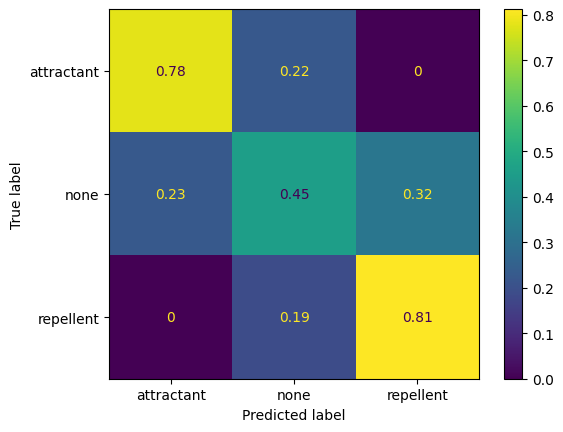

In [12]:
# Confusion matrix
Y_test_cm = Y_test.replace({1:'attractant', 0:'none', -1: 'repellent'})

# We consider that a value superior to 0.33 is an attractant and a value inferior to -0.33 is a repellent
threshold=0.33
def categorise(value):
    if value < -1*threshold:
        return "repellent"
    elif value > threshold:
        return "attractant"
    else:
        return "none"
Y_pred_cm = pd.Series(Y_pred).apply(categorise)
cm = confusion_matrix(Y_test_cm, Y_pred_cm, normalize="true")

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['attractant','none','repellent']).plot()

Let's have a look at the most important input features (the ones with the most 'weight')

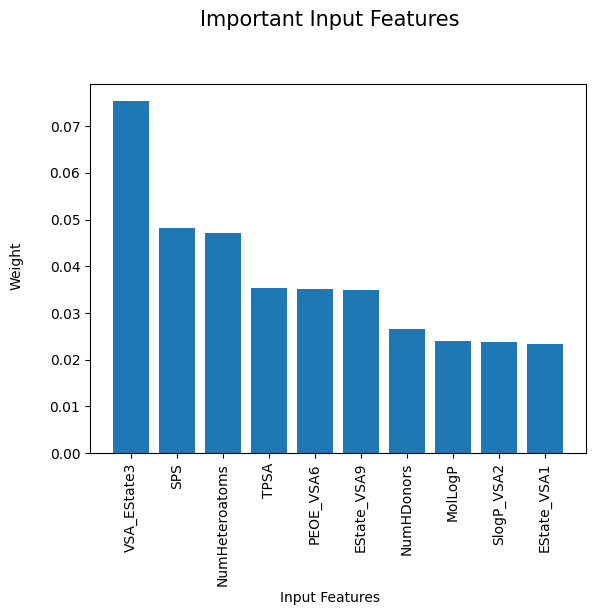

In [13]:
# Create a series containing feature importances from the model and feature names from the training data
important_features = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot the first 10
fig, ax = plt.subplots()
ax.bar(important_features.index[0:10],important_features[0:10])
ax.tick_params("x", labelrotation=90)

fig.text(0.5, 1, 'Important Input Features', ha='center', fontsize = 15)
fig.text(0.5, -0.2, 'Input Features', ha='center')
fig.text(0, 0.5, 'Weight', va='center', rotation='vertical')
plt.show()

If the inputs have fingerprints, let's draw the 5 most important fingerprints.

In [14]:
if data_type == 'fingerprint' or data_type == 'descrfp':
    # First, identify a molecule that has the fingerprints 'on' (1)
    ids = [int(i.split('_')[-1]) for i in important_features.index[:10] if 'Fingerprint' in i]
    if ids:
        print(ids)
        for i in ids:
            # Find a molecule possessing the fingerprint
            mol_matches = data.loc[data[f'Fingerprint_{i}'] == 1][smiles_column]
            mol = Chem.MolFromSmiles(mol_matches.values[0])
        
            ##### Get fingerprint of this molecule again
            if fp_type == 'rdkit':
                bi = {}
                fp =  Chem.RDKFingerprint(mol, fpSize = nBits, bitInfo = bi)
                img = Draw.DrawRDKitBit(mol, i, bi)
            elif fp_type == 'morgancirc':
                bi = {}
                fp =  Chem.AllChem.GetMorganFingerprintAsBitVect(mol, nBits = nBits, radius = 2, bitInfo=bi)
                img = Draw.DrawMorganBit(mol, i, bi)
            else:
                print('Fingerprint cannot be drawn')
            display(img)
    else:
        print('No fingerprints founds in the 10 most important features for this model...')
else:
    print('Molecular fingerprints were not used for this model')

Molecular fingerprints were not used for this model


If the inputs have molecular descriptors, we can compare the average of each important descriptors features for each categories.

In [15]:
if data_type == 'descriptors' or data_type == 'descrfp':
    # First, identify a molecule that has the fingerprints 'on' (1)
    ids = [i for i in important_features.index[:10] if 'Fingerprint' not in i]
    responses = ['attractant', 'none', 'repellent']
    
    if ids:
        # Create a dictionary
        imp_descr = {'Descriptor': [], 'Response': [], 'Average': [], 'Std': []}
        # Check if descriptors have been scaled
        if scaling:
            # Reload the descriptors
            descr = pd.read_csv('chemoeffectors_2Ddescriptors.csv')
        else:
            # Copy the data
            descr = data.copy()
        # Loop over the important descriptors
        for d in ids:
            # Loop over the responses
            for r in responses:
                imp_descr['Descriptor'].append(d)
                imp_descr['Response'].append(r)
                imp_descr['Average'].append(np.mean(descr[d].loc[descr['Response']==r]))
                imp_descr['Std'].append(np.std(descr[d].loc[descr['Response']==r]))
        print(pd.DataFrame(imp_descr))
    else:
        print('No descriptors founds in the 10 most important features for this model...')
else:
    print('Molecular descriptors were not used for this model')

        Descriptor    Response     Average        Std
0      VSA_EState3  attractant   32.691871  32.145382
1      VSA_EState3        none   18.609040  16.387412
2      VSA_EState3   repellent    8.045965   5.437510
3              SPS  attractant   25.628710  16.183645
4              SPS        none   16.893867  11.882657
5              SPS   repellent   10.208615   2.884077
6   NumHeteroatoms  attractant    6.543478   4.780879
7   NumHeteroatoms        none    5.061856   2.631351
8   NumHeteroatoms   repellent    2.738636   1.634113
9             TPSA  attractant  117.019130  70.881787
10            TPSA        none   86.585876  43.027867
11            TPSA   repellent   48.653864  28.587279
12       PEOE_VSA6  attractant    0.207136   1.130566
13       PEOE_VSA6        none    8.002408  13.539715
14       PEOE_VSA6   repellent   15.176241  16.089691
15     EState_VSA9  attractant   17.760328   9.649899
16     EState_VSA9        none   12.769254   9.043226
17     EState_VSA9   repelle

#### Using receiver operating characteristic to plot the model

Attractant vs rest

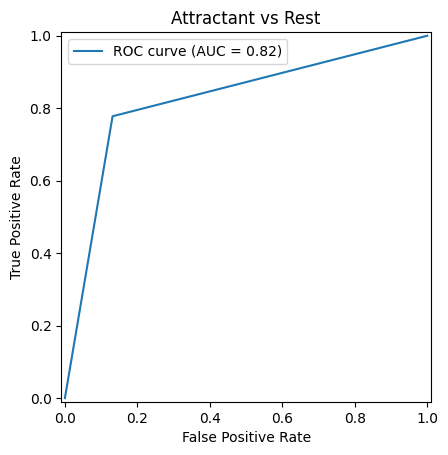

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
Y_test_binary = [1 if y > 1*threshold else 0 for y in Y_test]
Y_pred_binary = [1 if y > 1*threshold else 0 for y in Y_pred]
fpr, tpr, _ = roc_curve(Y_test_binary, Y_pred_binary)
auc = roc_auc_score(Y_test_binary, Y_pred_binary)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label=f'ROC curve (AUC = {auc:.2f})')
plt.title('Attractant vs Rest')
plt.legend(loc='best')
plt.show()

Repellent vs rest

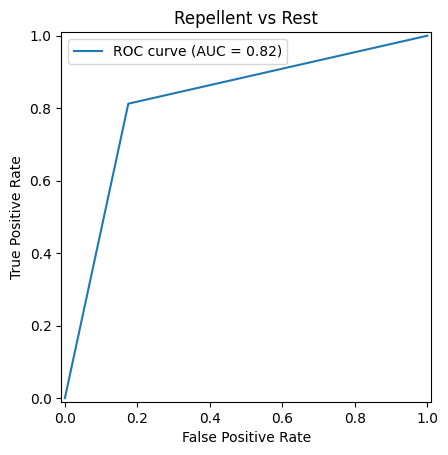

In [17]:
Y_test_binary = [1 if y < -1*threshold else 0 for y in Y_test]
Y_pred_binary = [1 if y < -1*threshold else 0 for y in Y_pred]
fpr, tpr, _ = roc_curve(Y_test_binary, Y_pred_binary)
auc = roc_auc_score(Y_test_binary, Y_pred_binary)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label=f'ROC curve (AUC = {auc:.2f})')
plt.title('Repellent vs Rest')
plt.legend(loc='best')
plt.show()

### Save the model

In [18]:
if save:
    with open(f'chemotaxis_{ml_method}_reg_model.pkl', 'wb') as f:
        pickle.dump(model, f)

#### Load and use the model for a prediction

In [19]:
with open(f'chemotaxis_{ml_method}_reg_model.pkl', 'rb') as f:
    ml_model = pickle.load(f)

# Do a prediction on X_test again
Y_new_pred = ml_model.predict(X_test)

Y_new_results = pd.concat([pd.concat([data.loc[[i for i in Y_test.index],['Chemoeffectors']],Y_test], axis=1).reset_index(),
           pd.DataFrame(Y_pred), pd.DataFrame(Y_new_pred)], ignore_index=True, axis=1)
Y_new_results.rename(columns={0: 'index', 1: 'Chemoeffectors', 2: 'Test', 3: 'Pred', 4: 'New_Pred'}, inplace=True)
Y_new_results

,index,Chemoeffectors,Test,Pred,New_Pred
0,254,2-(4-(methylsulfonyl)phenyl)acetic acid,0,-0.320000,-0.320000
1,220,nalidixic acid,-1,-0.400000,-0.400000
2,201,indole-2-carboxylate,0,-0.960000,-0.960000
3,171,2-amino-2-methyl-1-propanol,0,0.000000,0.000000
4,269,melatonin,-1,-0.440000,-0.440000
5,209,ethylbenzoate,-1,-0.920000,-0.920000
6,20,Isoasparagine,1,0.517612,0.517612
7,30,2-methylsuccinate,1,0.280000,0.280000
8,273,dopamine,1,-0.320000,-0.320000
9,42,L-alanine,1,0.200000,0.200000


NOTE: if the random state of the saved model was different than the new one, results will be slightly different

Now the model is ready to make predictions on new molecules. <br>
This will be illustrated in PART3